## Setup

In [9]:
from environment import CollisionChecker, construct_benchmark_environments
from planners.IPBasicPRM import BasicPRM
from planners.IPBasicPRM import BasicPRM

import pprint
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import importlib
import optimize_path

importlib.reload(optimize_path)
from optimize_path import OptimizeFlyby


## Load Environments

In [10]:
env_dict = construct_benchmark_environments()

## Create Planner and Collision Checker for each environment

In [11]:
for name, item in env_dict.items():
    cc = CollisionChecker(item["env"])
    planner = BasicPRM(cc)
    # Inject Graph
    G = nx.Graph()

    node_names = []

    for i, coord in enumerate(item["smooth_path"]):
        # Determine the name based on position in the list
        if i == 0:
            n = "start"
        elif i == len(item["smooth_path"]) - 1:
            n = "goal"
        else:
            n = f"{i}" # Naming middle nodes generically
        
        node_names.append(n)
        
        # Add node with the 'pos' attribute
        G.add_node(n, pos=coord)

    # Add edges connecting each node to the next
    for i in range(len(node_names) - 1):
        current_node = node_names[i]
        next_node = node_names[i+1]
        G.add_edge(current_node, next_node)

    planner.graph = G
    
    env_dict[name]["planner"] = planner



## Show the Environments

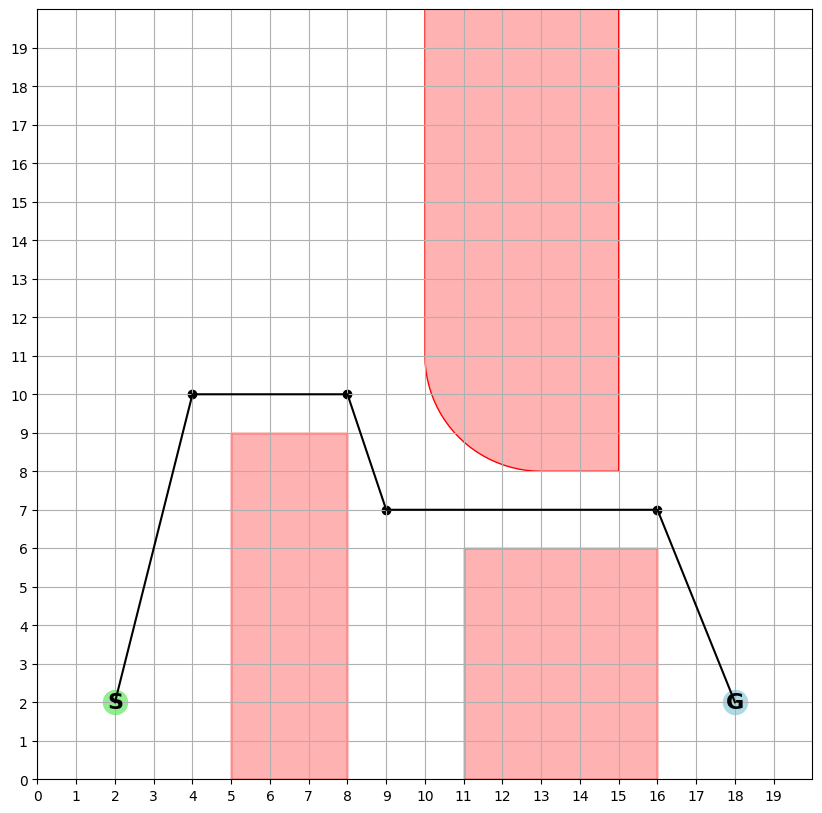

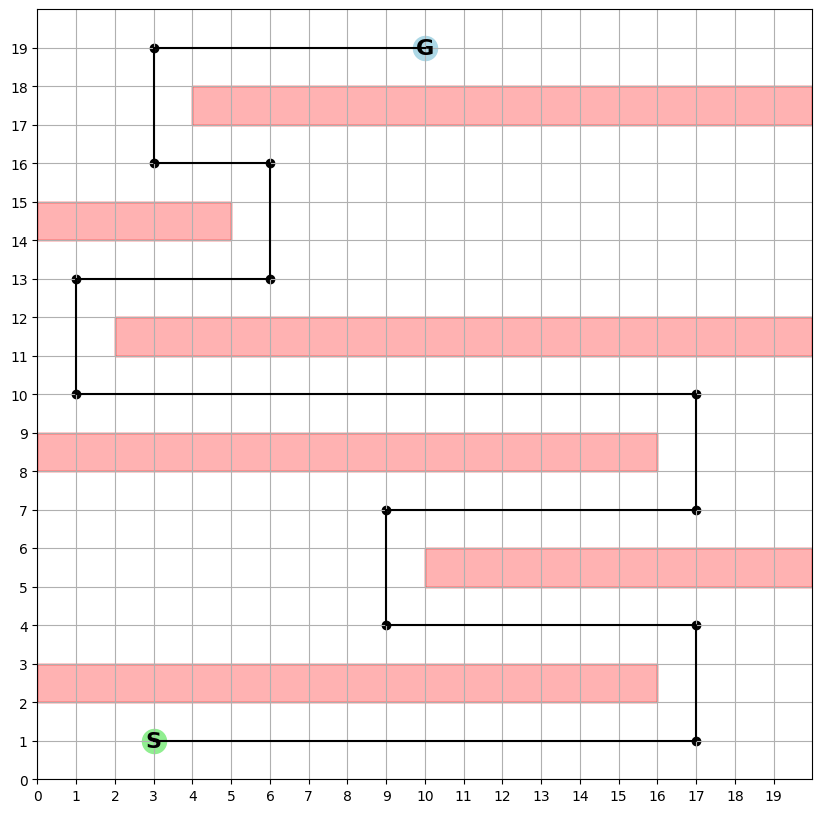

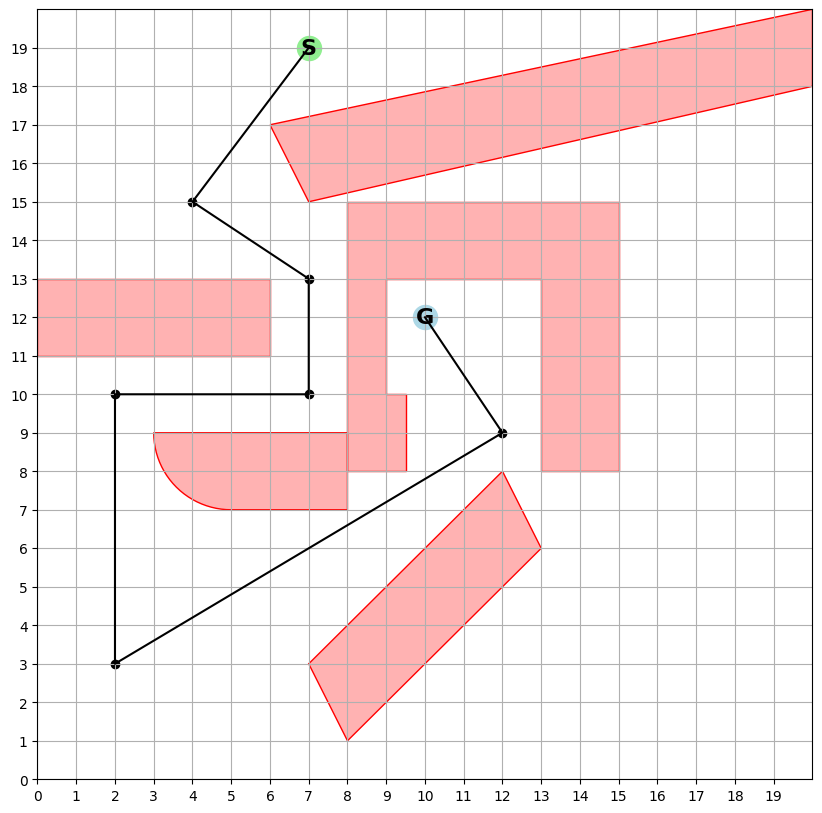

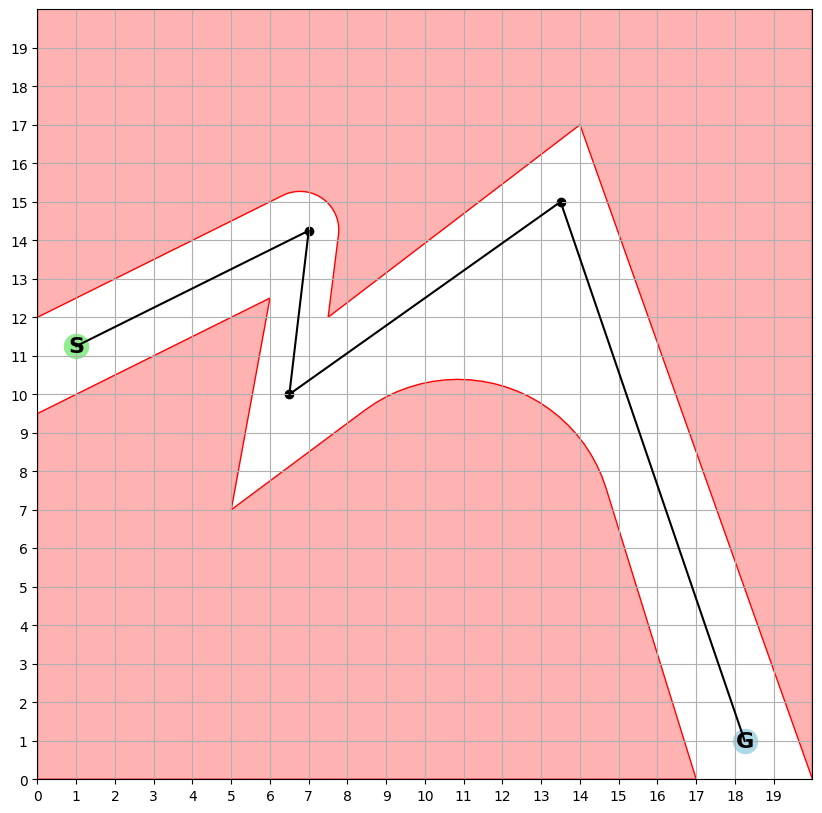

In [12]:
for name, item in env_dict.items():
    ax = item["planner"]._collisionChecker.draw_enviroments()
    item["planner"]._collisionChecker.draw_path(item["smooth_path"], ax=ax)


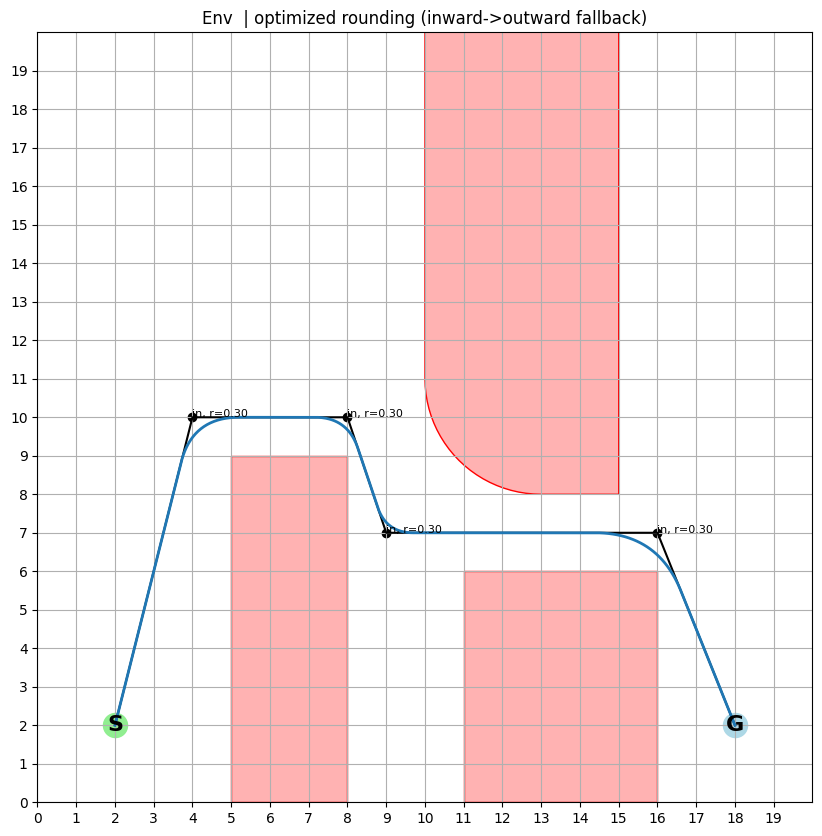

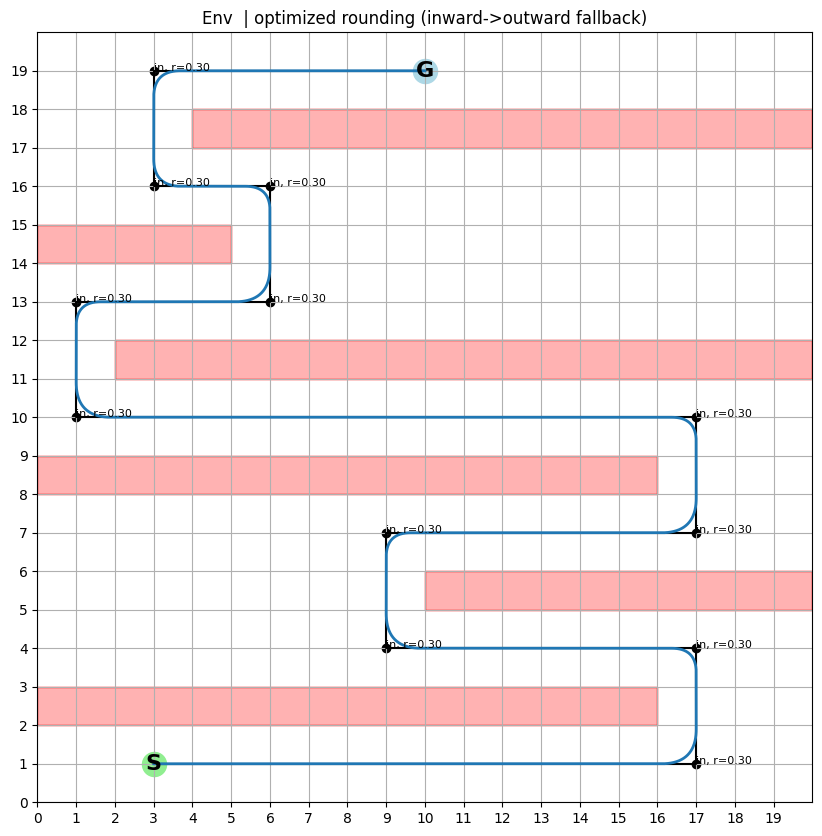

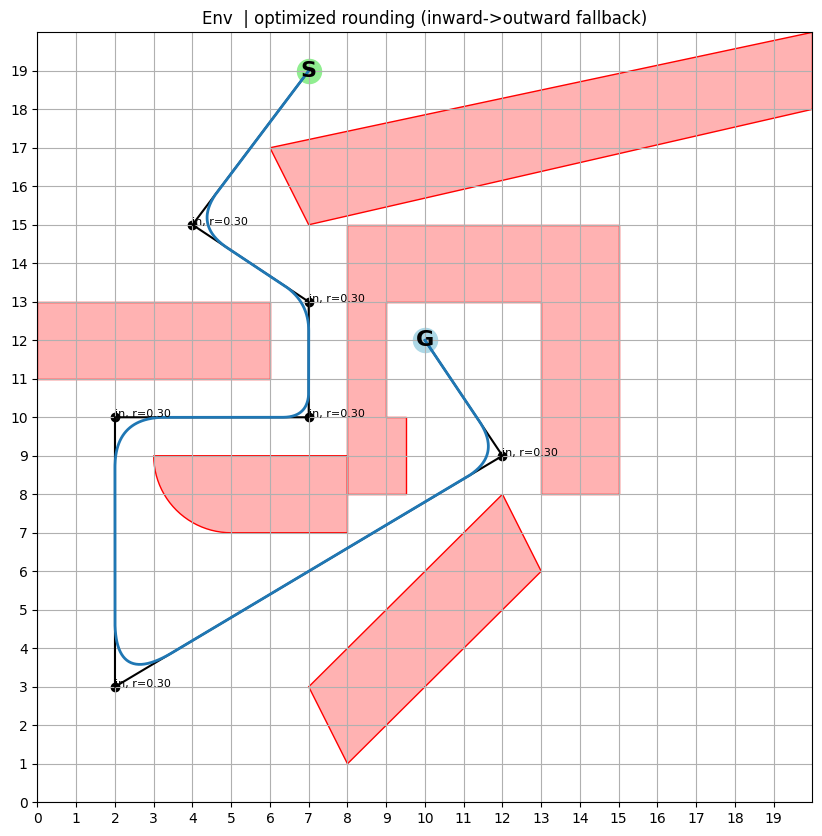

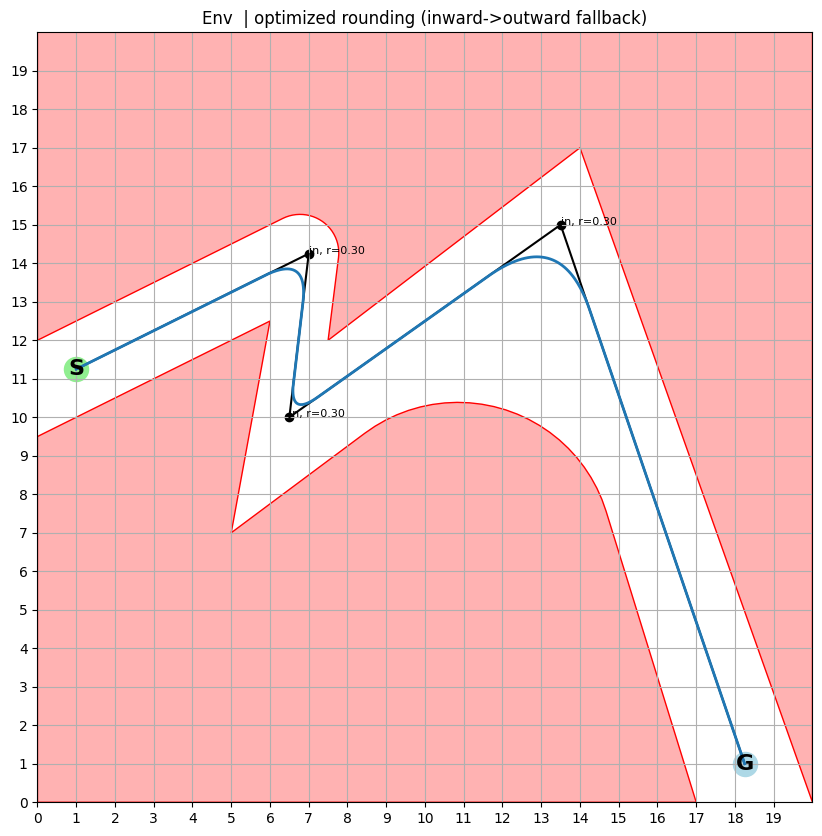

In [16]:
import importlib, optimize_path
importlib.reload(optimize_path)
from optimize_path import OptimizeFlyby
import numpy as np

def inject_path_as_graph(planner, smooth_path_positions):
    G = planner.graph
    G.clear()

    node_path = []
    G.add_node("start", pos=np.array(smooth_path_positions[0], dtype=float))
    node_path.append("start")

    for i in range(1, len(smooth_path_positions) - 1):
        name = str(i)
        G.add_node(name, pos=np.array(smooth_path_positions[i], dtype=float))
        node_path.append(name)

    G.add_node("goal", pos=np.array(smooth_path_positions[-1], dtype=float))
    node_path.append("goal")

    for a, b in zip(node_path[:-1], node_path[1:]):
        G.add_edge(a, b)

    return node_path

cfg = {
    "r": 0.30,
    "r_step": 0.02,
    "r_min": 0.02,
    "n_samples": 80
}

opt = OptimizeFlyby()

for name, item in env_dict.items():
    # Planner + CollisionChecker wie im Rest deines Notebooks
    cc = CollisionChecker(item["env"])
    planner = BasicPRM(cc)

    # Plot environment + original path (so wie du es gewohnt bist)
    ax = planner._collisionChecker.draw_enviroments()
    planner._collisionChecker.draw_path(item["smooth_path"], ax=ax)

    # Originalpfad als Graph-Knoten injizieren
    original_nodes = inject_path_as_graph(planner, item["smooth_path"])

    # Optimieren (inward first, outward fallback)
    optimized_nodes, r_used, side_used = opt.optimizePath(original_nodes, planner, cfg)

    # Optimierten Pfad plotten (nur Linie, keine Punkte)
    G = planner.graph
    opt_positions = np.array([G.nodes[n]["pos"] for n in optimized_nodes], dtype=float)
    ax.plot(opt_positions[:, 0], opt_positions[:, 1], linewidth=2)

    # Optional: an den ORIGINAL-Eckpunkten anzeigen ob in/out + r
    for node in original_nodes[1:-1]:
        side = side_used.get(node, "none")
        rval = r_used.get(node, 0.0)
        if side in ("in", "out") and rval > 0:
            p = planner.graph.nodes[node]["pos"]
            ax.text(p[0], p[1], f"{side}, r={rval:.2f}", fontsize=8)

    ax.set_title(f'Env {item.get("id","")} | optimized rounding (inward->outward fallback)')
    plt.show()
